In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import LinearNDInterpolator

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200


plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"
})

In [36]:
masses = np.arange(8, 21) # Msun
mass_range = np.linspace(np.min(masses), np.max(masses), int(1e3))

couplings = [ -10, -9, -8, -8.5 ]

age_range = np.linspace(0, 50, 100) # in Mya

colormap_m = plt.cm.ScalarMappable( 
    colors.Normalize(np.min(masses), np.max(masses)),
    plt.get_cmap(f'winter')
)

colormap_g = plt.cm.ScalarMappable( 
    colors.Normalize(np.min(couplings), np.max(couplings)),
    plt.get_cmap(f'winter')
)

colormap_age = plt.cm.ScalarMappable( 
    colors.Normalize(np.min(age_range), np.max(age_range)),
    plt.get_cmap(f'winter')
)

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]


labels = list(({
    # 'model': 'slice',
    'm': 'mass (Msun)',
    # 'coupling': 'coupling',
    'age': 'age (years)',
    # 'til': 'time to core O depletion (years)',
    # 'dt': 'dt (years)',
    
    # 'm_enc': 'mass enclosed (Msun)',
    # 'dm': 'dm (g)',
    # 'r': 'r (Rsun)',
    # 'dr': 'dr (cm)',
    # 'T': 'T (K)',
    # 'T_core': 'core T (K)',
    'T_eff': 'effective T (K)',
    # 'log_T': 'log T',
    
    # 'eps_grav': 'eps_grav (ergs/g s)',
    # 'eps_nuc': 'eps_nuc (ergs/g s)', 
    # 'eps_non_nuc_neu': 'eps_neu (ergs/g s)',
    # 'eps_a': 'eps_a (ergs/g s)',
    
    # 'lum_gamma': 'lum_gamma (ergs/s)',
    # 'lum_neu': 'lum_neu (ergs/s)',
    # 'lum_a': 'lum_a (ergs/s)',
    
    'lum_gamma_surf': 'surface lum_gamma (ergs/s)',
    # 'lum_neu_surf': 'surface lum_neu (ergs/s)',
    # 'lum_a_surf': 'surface lum_a (ergs/s)',
    
    # 'cum_e_gamma': 'cumulative e_gamma (ergs)',
    # 'cum_e_neu': 'cumulative e_neu (ergs)',
    # 'cum_e_a': 'cumulative e_a (ergs)',
}).values())

lumSun = 3.846e33 # ergs/s

# crank this up for full thing
max_slices = 10000

In [37]:
datatable = dict()

for m in masses:
    datatable[m] = dict()
    for g in couplings:
        try:
            key = f'm{m:04.1f}_g{g:+04.2f}'
            run = pd.read_csv(f'csv/{key}/index.csv')
            entry = run[labels].to_numpy()[:max_slices].T
            datatable[m][g] = entry
            print(key, end=',\t')
        except FileNotFoundError as e:
            print(e)

m08.0_g-10.00,	m08.0_g-9.00,	m08.0_g-8.00,	m08.0_g-8.50,	m09.0_g-10.00,	m09.0_g-9.00,	m09.0_g-8.00,	m09.0_g-8.50,	m10.0_g-10.00,	m10.0_g-9.00,	m10.0_g-8.00,	m10.0_g-8.50,	m11.0_g-10.00,	m11.0_g-9.00,	m11.0_g-8.00,	m11.0_g-8.50,	m12.0_g-10.00,	m12.0_g-9.00,	m12.0_g-8.00,	m12.0_g-8.50,	m13.0_g-10.00,	m13.0_g-9.00,	m13.0_g-8.00,	m13.0_g-8.50,	m14.0_g-10.00,	m14.0_g-9.00,	m14.0_g-8.00,	m14.0_g-8.50,	m15.0_g-10.00,	m15.0_g-9.00,	m15.0_g-8.00,	m15.0_g-8.50,	m16.0_g-10.00,	m16.0_g-9.00,	m16.0_g-8.00,	m16.0_g-8.50,	m17.0_g-10.00,	m17.0_g-9.00,	m17.0_g-8.00,	m17.0_g-8.50,	m18.0_g-10.00,	m18.0_g-9.00,	m18.0_g-8.00,	m18.0_g-8.50,	m19.0_g-10.00,	m19.0_g-9.00,	m19.0_g-8.00,	m19.0_g-8.50,	m20.0_g-10.00,	m20.0_g-9.00,	m20.0_g-8.00,	[Errno 2] No such file or directory: 'csv/m20.0_g-8.50/index.csv'


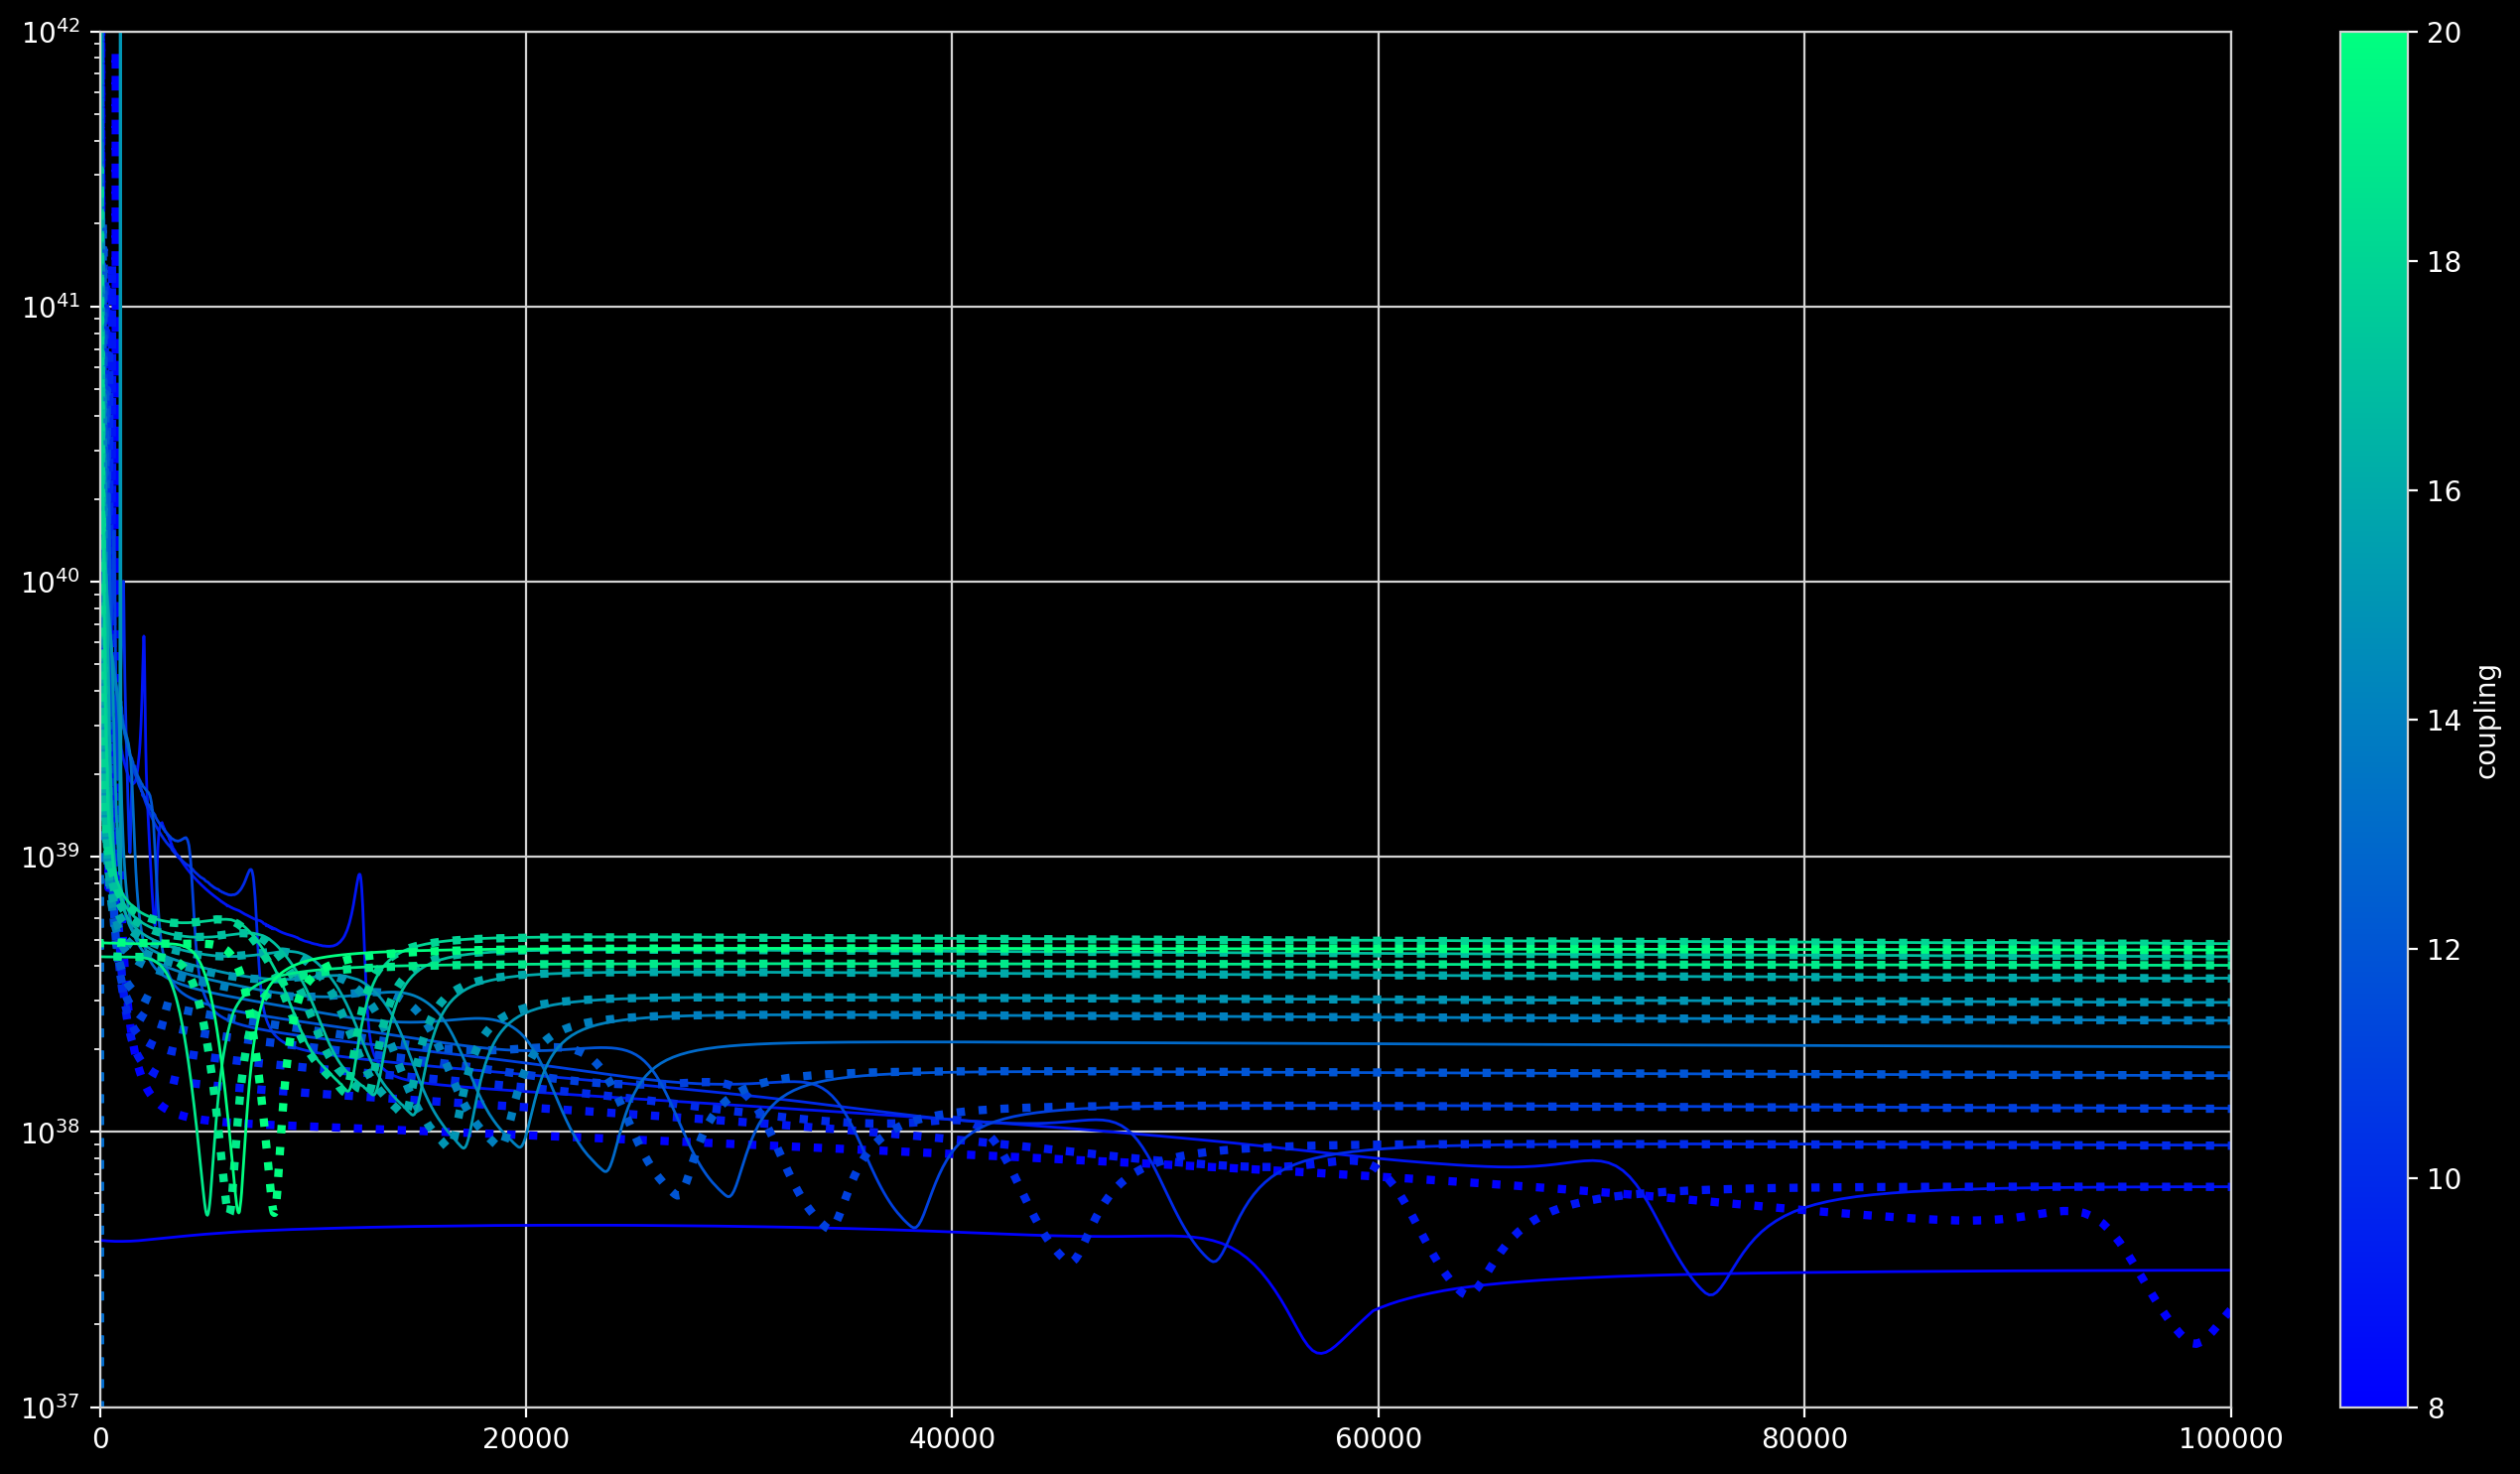

In [45]:
fig, (main_ax, color_ax) = plt.subplots(ncols=2, figsize=(15, 9), 
                                        gridspec_kw={'width_ratios': [32, 1], 'wspace': 0.1 }
                                       )
main_ax.set_facecolor('black')
fig.colorbar(colormap_m, label='coupling', cax=color_ax)
###

plt.sca(main_ax)
main_ax.set_yscale('log')
# main_ax.set_xscale('log')

for m in masses:
    a = datatable[m][-10]
    b = datatable[m][-8]
    x = a[1]
    y = np.interp(a[1], b[1], b[3])
    plt.plot(a[1][-1] - a[1], a[3], c=colormap_m.to_rgba(m), lw=1)
    plt.plot(b[1][-1] - b[1], b[3], c=colormap_m.to_rgba(m), lw=3, ls=":")
    # plt.plot(x, y, c=('red' if Tend < Tcut else 'blue'))

# plt.xlabel('Surface temperature (K)')
# plt.ylabel('Surface photon luminosity (ergs/s)')
plt.xlim(0, 1e5)
plt.ylim(1e37, 1e42)
plt.grid()

# plt.title(f'Hertzsprung-Russel, log $g = {G}$', c='white')
# plt.legend()
plt.show()